In [1]:
import networkx as nx
import pandas as pd
import ndlib.models.epidemics as ep
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
import ndlib.models.ModelConfig as mc
from ndlib.viz.bokeh.MultiPlot import MultiPlot
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Helper functions

def config_SIR(model, beta, gamma, fraction_infected):
    '''Takes the SIR model as input and its parameters
    Configures said model with these parameters.'''
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(config)
    
    
def get_SIR_result_lists(results):
    '''Takes SIR simulation results (model.build_trends(iterations)) as input variable
    Unpacks this variable and outputs S, I, R node count as lists.'''
    S_node_count = results[0]['trends']['node_count'][0]
    I_node_count = results[0]['trends']['node_count'][1]
    R_node_count = results[0]['trends']['node_count'][2]
    return S_node_count, I_node_count, R_node_count

**Investigate the effect of network parameters on the spread**

In [ ]:
#Simulate Erdos-Reyni (random) network. Investigate the effect of p on the spread of disease (SIR).

p_variations = [0.04, 0.07, 0.1, 0.13, 0.16]
beta = 0.001
gamma = 0.01
fraction_infected = 0.05
time_steps = 200
N = 1000

time = np.linspace(0, time_steps, time_steps)
plt.figure(figsize=(10, 6))

for p in p_variations:
    # Network Definition
    g = nx.erdos_renyi_graph(N, p)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
    
    #Plot
    plt.plot(time, I_node_count, label = f'p = {p}')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected nodes')
    plt.title('The effect of parameter p on the spread of disease (SIR)\nin the Erdos-Reyni (random) network')
    plt.legend()
    plt.grid(True)

In [ ]:
#Simulate Barabasi Albert (scale-free) network. Investigate the effect of m on the spread of disease (SIR).

m_variations = [1, 2, 3, 4, 5]
beta = 0.3
gamma = 0.1
fraction_infected = 0.05
time_steps = 30
N = 1000

time = np.linspace(0, time_steps, time_steps)
plt.figure(figsize=(10, 6))

for m in m_variations:
    # Network Definition
    g = nx.barabasi_albert_graph(N, m)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
    
    #Plot
    plt.plot(time, I_node_count, label = f'm = {m}')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected nodes')
    plt.title('The effect of parameter m on the spread of disease (SIR)\nin the Barabasi Albert (scale-free) network')
    plt.legend()
    plt.grid(True)

In [ ]:
#Simulate Watts-Strogatz (small worlds) network. Investigate the effect of k on the spread of disease (SIR).

k_variations = [5, 7, 9, 11, 13]
prob = 0.05
beta = 0.3
gamma = 0.1
fraction_infected = 0.05
time_steps = 30
N = 1000

time = np.linspace(0, time_steps, time_steps)
plt.figure(figsize=(10, 6))

for k in k_variations:
    # Network Definition
    g = nx.watts_strogatz_graph(N, k, prob)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
    
    #Plot
    plt.plot(time, I_node_count, label = f'm = {k}')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected nodes')
    plt.title('The effect of parameter k on the spread of disease (SIR)\nin the Watts-Strogatz (small worlds) network')
    plt.legend()
    plt.grid(True)
    
    
#Simulate Watts-Strogatz (small worlds) network. Investigate the effect of p (prob) on the spread of disease (SIR).

k = 5
prob_variations = [0.05, 0.10, 0.15, 0.25]
beta = 0.3
gamma = 0.1
fraction_infected = 0.05
time_steps = 30
N = 1000

time = np.linspace(0, time_steps, time_steps)
plt.figure(figsize=(10, 6))

for prob in prob_variations:
    # Network Definition
    g = nx.watts_strogatz_graph(N, k, prob)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
    
    #Plot
    plt.plot(time, I_node_count, label = f'p = {prob}')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected nodes')
    plt.title('The effect of parameter p on the spread of disease (SIR)\nin the Watts-Strogatz (small worlds) network')
    plt.legend()
    plt.grid(True)

**Generate Networks of equivalent form**

## Vaccination

In [2]:
# Read your data into a Pandas DataFrame
data = pd.read_csv('transmission_network.csv', delimiter=';')

In [3]:
print(data.shape)

(374, 375)


In [4]:
data = data.drop(columns=['Unnamed: 0'])  # Remove the extra column
adjacency_matrix = data.values

In [5]:
G = nx.Graph(adjacency_matrix)

In [6]:
print("Number of nodes:", len(G.nodes()))
print("Number of edges:", len(G.edges()))

Number of nodes: 374
Number of edges: 1265


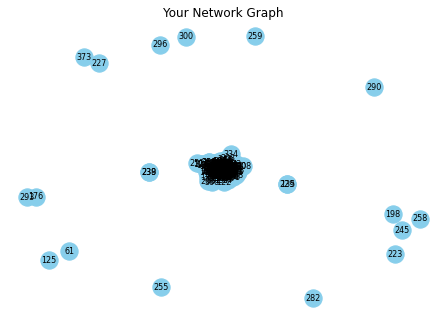

In [7]:
# Create a layout for the graph
layout = nx.spring_layout(G)

# Draw the nodes and edges
nx.draw(G, layout, with_labels=True, node_size=300, node_color='skyblue', font_size=8)

# Draw edge weights, if available
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, layout, edge_labels=labels, font_size=8)

# Show the graph
plt.title("Your Network Graph")
plt.show()